# SpotiPy Project
### Owen Yaggy, Luke Sheppard, Felicia Pursner
#### Relating people by their musical choices

## Importing libraries:
All the libraries that could be needed. This is directly from the Encoding Music tutorial on Spotify functions on GitHub.

In [194]:
!pip -q install spotipy

In [178]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from ipywidgets import interactive
from IPython.display import display
import plotly.express as px

# The `analyze_playlists()` function from the Encoding Music GitHub uses pd.concat in a way that causes FutureWarnings to be thrown, warning about deprecation of a particular usage of pd.concat.
# This workaround code tells Python to ignore those warnings and not display them.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Configuring the Spotify API

This code uses the Spotify API. It requires a client ID, a client secret, and a Spotify username. Those can be included in the code in the following two ways:

* A file, config.py, with variables for `client_id`, `client_secret`, and `user` stored as strings. These correspond to your public and private Spotify API keys, and your Spotify username, respectively, OR:
* Replace the usage of `config.client_id` with your private API key, and so on for the other variables. They are only used once, in the cell below.
    * If this method is used, comment out the line `import config` - if there is no `config.py` file, this line will cause an error.

This cell takes the API credentials and stores them with the client tool provided by the spotipy library.

In [179]:
# Comment this out if storing your API keys below!
import config

# storing the credentials:

CLIENT_ID = config.client_id
CLIENT_SECRET = config.client_secret
my_username = config.user

# instantiating the client.  This 'sp' version of the client is used repeatedly below
# source: Max Hilsdorf (https://towardsdatascience.com/how-to-create-large-music-datasets-using-spotipy-40e7242cc6a6)
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Get music feature data
#### This is needed to analyze the songs and determine similarity.

*This code is taken from the EncodingMusic GitHub, in spotify_tools.py, but MODIFIED as follows:*

* Previously, the index of every song in the dataframe was sequential (0, 1, 2, etc.)
* This made it hard for me to query a specific audio feature for a track
* So, the code was changed so that the index becomes the track_id for a song
* This means you can query based on track_id, which makes it easier to find specific data for a song
* If a playlist contains several copies of the same song, duplicate copies are now ignored
* All song IDs needed are now collected PRIOR to making an API call, so only one call is made rather than 10 to collect audio feature data.

In [180]:
def analyze_playlist(creator, playlist_id, spotipy_client):
    playlist_features_list = ["artist", "album", "track_name",
                              "danceability", "energy", "key", "loudness", "mode", "speechiness",
                              "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"] # removed track_id
    playlist_df = pd.DataFrame(columns=playlist_features_list)

    playlist_features = {}

    playlist = spotipy_client.user_playlist_tracks(creator, playlist_id)["items"]
    
    ### Modification from original code to reduce API calls by 90%:
    # First gather all the tracks in the playlist, and make one batch API call to get audio features for all those tracks
    # Instead of making a new API call for each track
    
    tracks = []                                 # List to contain all track IDs
    for track in playlist:                      # Iterate thru tracks in playlist
        tracks.append(track['track']['id'])     # Store track ID in list
    
    audio_features = spotipy_client.audio_features(tracks)
    
    for track in playlist:
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]

        for feature in playlist_features_list[3:]: # changed from 4 to 3 to fix error caused by removing track_id from list of features
            # modified to also select the specific audio feature data needed based on current track, since now `audio_features` contains data for 10 songs
            playlist_features[feature] = audio_features[tracks.index(playlist_features['track_id'])][feature]

        track_df = pd.DataFrame(playlist_features, index=[playlist_features['track_id']]) # changed index from automatically being 0 to being the track_id
        
        try:                                                        # attempts to query the current song in the resultant dataframe
            playlist_df.loc[playlist_features['track_id']]          # only if the song is not already in the df (which throws KeyError) will it be added
        except KeyError:
            playlist_df = pd.concat([playlist_df, track_df], ignore_index=False) # changed ignore_index from True to False

    return playlist_df

The variables below will be used for some examples later on:

In [181]:
creator_id_1 = "owenyyyyy"                  # Owen Yaggy
playlist_id_1 = "7IQjZlOVWHRryiAe5Bmb3F"    # Playlist: "Pandemic Indie Phase"
track_id_1 = "2c62Xf5Po1YSa1N6LOjPHy"       # Song: Hello My Old Heart by The Oh Hellos

creator_id_2 = "lzsfootball"                # Luke Sheppard
playlist_id_2 = "2C4SW8Xfa1WxaO6b2dabOA"    # Playlist: "Oranges"
track_id_2 = "5VGEgFZfWBoEOGb3Vlo3rU"       # Song: Tangerine by Glass Animals

# Fundamental Comparison: Song <-> Song

While we ultimately aim to relate people, the fundamental comparison is a scalar indicating the similarity of two songs.

The main function is `similarity_scalar(...)`:
 `similarity_scalar(song_id_1, playlist_dataframe_2, song_id_2, playlist_dataframe_2)`
 
`similarity_scalar(...)` takes two song IDs and their respective dataframes and generates a scalar from 0-1. 1 indicates complete similarity, and 0 indicates complete difference. This value is based on the average difference of audio feature data for the two tracks.

Those differences in audio feature data are easy to compute for quantities that are already scalar, such as `valence` and `energy`. However, some audio features require interpretative methods of comparison. One notable example is `key`. When comparing two keys, we take into account the `mode` as well. Using `key` and `mode`, we locate each track on the circle of fifths. The difference between the keys of two tracks is the distance between their relative positions on the circle of fifths, converted to a scalar from 0 to 1.

A separate function is written for this computation:

In [182]:
def compare_keys(key1: int, mode1: int, key2: int, mode2: int) -> float:
    """
    Returns how similar the key of 2 tracks is based on their relative positions in the circle of fifths.
    
    For example, C major and A minor both occupy the same position on the circle of fifths (position 0). G maj/E min is position 2. D maj/B min is position 3,
    and so on up to F maj/D min at position 11.
    
    This function uses key and mode information provided by Spotify to calculate the position of each track on the circle of fifths.
    The circle has 12 positions, so the minimum distance between two points is 0, and the maximum distance is 6, because the circle is bidirectional.
    The function returns a scalar from 0-1, where 1 represents the maximum distance and 0 the minimum. Thus, the result is 1/6 of the distance on the circle.
    :param key1: Key of the first track
    :param mode1: Mode of the first track
    :param key2: Key of the second track
    :param mode2: Mode of the second track
    :return: A float from 0-1, with 1 indicating far apart keys, and 0 indicating identical keys
    """
    # Similar means similar audio feature values. Thus returning 0 means very similar, and 1 means very different.
        
    circle_pos_1 = (7 * key1) % 12      # increase of 1 on the Spotify scale = up a half step
                                        # but increase of a half step on the circle of fifths = up 7 positions (but max position is 11)
    
    if mode1 == 0:                                  # however, if the key is actually a minor key, need to shift back 3 positions (equivalent to up 9)
        circle_pos_1 = (circle_pos_1 + 9) % 12      # because, for example, C maj has position 0, but C min has position 9, on the circle of fifths
    
    circle_pos_2 = (7 * key2) % 12      # calculate the position on the circle of fifths for the other song in the same way
    if mode2 == 0:
        circle_pos_2 = (circle_pos_2 + 9) % 12
        
    circle_dist = abs(circle_pos_1 - circle_pos_2)      # calculate the distance between the 2 positions on the circle
    if circle_dist > 6:                                 # because circle is bidirectional, differences greater than 6 are actually closer than 6
        circle_dist = 12 - circle_dist
        
    return circle_dist / 6      # convert to 0-1 scalar

## Finding Audio Feature Difference

The first step is a function that takes the data from two songs and finds the difference in audio features for the two tracks. This is accomplished in `similarity_dict(...)`.

In `similarity_dict(...)`:
    * Audio feature data is stored in a dictionary for each track
    * The difference between the values for each feature is computed
        * So, a small number for `valence` indicates 2 tracks have very similar valence, while a large number indicates very different valence
        * For scalar features (those measured from 1-0), this is a simple process
        * Some features just need to be translated to a different scale (e.g. `loudness` can be transposed from a -60 to 0 scale to a 0 to 1 scale) (see the code for step-by-step comments)
        * For comparing keys, a more complicated algorithm is needed to account for similar keys (see `compare_keys(...)`)
    * The output is a dictionary where each entry is measures how similar a feature is, for example `'valence': 0.03` indicates similar valence

##### An important note

When comparing two songs, audio features play differently sized roles in determining how similar they sound. Our code accounts for this by allowing the weight of each audio feature to be selected. We also set default values to account for the usefulness of some of the audio feature comparisons.

For instance, loudness is measured on a logarithmic scale. Comparisons on this scale aren't very useful, and loudness as a feature is somewhat arbitrary because the same recording could be mixed with a higher or lower decibel level. By default, we ignore loudness, setting its weight to 0, when we compare playlists. However, we leave the code intact, both for future modification and in case the user decides a comparison of loudness could be useful. We also give mode very little weight, for example, because whether a track is in a major or minor key is likely an insignificant factor in determining similarity. In recognition of the subjective nature of these weights, we allow the user to select the weights they would like to use through sliders. This is discussed later.

For more information on audio feature weighting, see the `set_weights()` function.

In [183]:
def similarity_dict(id1: str, playlist_df_1_param: pd.DataFrame, id2: str="", playlist_df_2_param: pd.DataFrame=pd.DataFrame()) -> dict:
    """
    Returns a dictionary with the similarity of each audio feature for the tracks in the given playlists. Smaller numbers mean more similar. If both songs are from the same playlist, only one playlist dataframe is needed.
    :param id1: The Spotify ID of the first song
    :param playlist_df_1_param: The dataframe for the first playlist
    :param id2: (Optional) The Spotify ID of the second song
    :param playlist_df_2_param: (Optional) The dataframe for the second playlist
    :return: A dictionary with keys indicating audio features and values indicating the difference between the values for those features from the respective tracks. Values closer to 0 indicate similarity, and values closer to 1 indicate difference.
    """
    
    if playlist_df_2_param.empty:                   # if only one playlist given
        playlist_df_2_param = playlist_df_1_param   # use the first playlist as the second playlist
    
    # A list of features to compare:
    features = ['danceability', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo', 'key', 'mode']
    
    track1 = playlist_df_1_param.loc[id1] # variable containing all feature data from track 1
    track2 = playlist_df_2_param.loc[id2] # variable containing all feature data from track 2
    
    # Store all music feature data in dictionary form:
    # The important part of this code is converting everything to a number (not a string) that can be manipulated
    track1_features = {}
    track2_features = {}
    for feature in features:
        track1_features[feature] = track1.get(feature)
        track2_features[feature] = track2.get(feature)
    
    feature_similarities = {}
    for feature in features:
        if feature not in ['loudness', 'tempo', 'mode', 'key']:     # these features aren't stored as scalars, meaning their comparisons need to be handled differently
            # Compute the difference between the feature data for each track
            feature_similarities[feature] = abs(track1_features[feature] - track2_features[feature])
            
        if feature == 'loudness':
            feature_similarities[feature] = abs(track1_features[feature] - track2_features[feature]) * (1/60)  # loudness is stored -60 to 0, this converts the difference to a positive scalar
            # In rare cases, loudness falls outside the -60 to 0 range. If so, the code to scale down the difference between loudness to a scalar might result in a value over 1.
            # This code caps the maximum amount of difference at 1 - in other words, tracks that have over 60 dB of loudness difference are treated as having 60 dB of loudness difference.
            if feature_similarities[feature] > 1:
                feature_similarities[feature] = 1
                
        if feature == 'tempo':
            # Tempo is measured in BPM. This could be any positive integer, but most are within a range of 40-200 BPM.
            # For the purpose of comparison, tracks under 40 BPM are treated as having a BPM of 40. Tracks over 200 are treated as having a BPM of 200.
            # Thus, the maximum difference is 160, and the minimum is 0.
            # So to convert to a scalar, the difference between BPM is divided by 160.
            if track1_features[feature] < 40:
                track1_features[feature] = 40
            if track1_features[feature] > 200:
                track1_features[feature] = 200
            if track2_features[feature] < 40:
                track2_features[feature] = 40
            if track2_features[feature] > 200:
                track2_features[feature] = 200
            
            feature_similarities[feature] = abs(track1_features[feature] - track2_features[feature]) * (1/160)
            
        if feature == 'key':
            feature_similarities[feature] = compare_keys(track1_features['key'], track1_features['mode'], track2_features['key'], track2_features['mode'])
        
        if feature == 'mode':
            feature_similarities[feature] = float(abs(track1_features[feature] - track2_features[feature]))     # converted to float (from int) for uniformity, no practical effect
    
    return feature_similarities

playlist_df_1 = analyze_playlist(creator_id_1, playlist_id_1, sp)
playlist_df_2 = analyze_playlist(creator_id_2, playlist_id_2, sp)
similarity_dict(track_id_1, playlist_df_1, track_id_2, playlist_df_2)

{'danceability': 0.2879999999999999,
 'energy': 0.284,
 'instrumentalness': 0.030264,
 'liveness': 0.00860000000000001,
 'valence': 0.5449999999999999,
 'loudness': 0.0781,
 'tempo': 0.37412500000000004,
 'key': 0.0,
 'mode': 1.0}

## Create a Radar Plot

We can visualize the results of `similarity_dict(...)` using a radar plot:

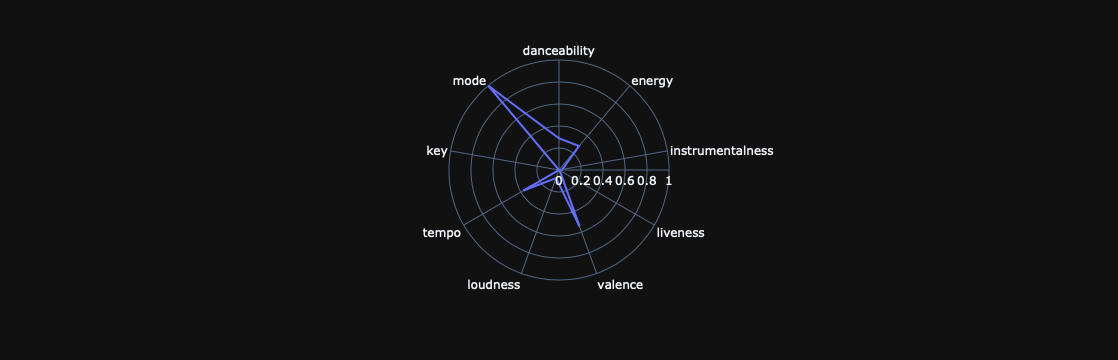

In [201]:
def dict_to_list(dictionary):
    """Separate the audio features and their values into distinct lists"""
    keys = []
    values = []
    
    for key in dictionary:
        keys.append(key)
        values.append(dictionary[key])
    return keys, values

def make_radar(tuple_keys_val):
    """Create a radar plot based on the results of the similarity_dict() function"""
    df = pd.DataFrame(dict(
        r=tuple_keys_val[1],
        theta=tuple_keys_val[0]))
    fig = px.line_polar(df, r='r', theta='theta', line_close=True)
    fig.show()

comp_1 = similarity_dict(track_id_1, playlist_df_1, track_id_2, playlist_df_2)
radar_val = dict_to_list(comp_1)
make_radar(radar_val)

## Find Average Difference (Similarity) from `similarity_scalar_from_dict(...)`

The next step is finding the average difference in audio features. This is accomplished in `similarity_scalar_from_dict(...)`:
    * The dictionary resulting from `similarity_dict(...)` is taken as an input
    * Every difference between similarities is summed
    * This number is divided by the total number of audio features (we use 9)
    * The result is a number between 0-1, where 0 represents identical, and 1 represents completely different
    * However, we want 1 to represent identical, and 0 to represent completely different, so we invert this scale (subtracting the number we got before from 1)

In [184]:
def similarity_scalar_from_dict(feature_similarities: dict, **weights) -> float:
    """
    Returns a scalar from 0-1 that tells you how similar two songs are based on a mash-up of their audio features.
    By default, each audio feature is weighted equally in comparison (weight = 1). However, you can include a parameter for any audio feature you want.
    Setting this value to 0, for example, will give that feature no weight. Setting it to 4 will make that feature 4x as important as every other feature.
    Example usages:
        * `similarity_scalar_from_dict(feature_similarities)`
        * `similarity_scalar_from_dict(feature_similarities, valence=4)`
        * `similarity_scalar_from_dict(feature_similarities, valence=4, mode=0, key=10)`
    :param feature_similarities: A dictionary returned by `similarity_dict(...)`
    :param weights: Keyword arguments for each audio feature are allowed. Their values should be floats in the range [0, ∞). Allowable audio features are `danceability`, `energy`, `instrumentalness`, `liveness`, `valence`, `loudness`, `tempo`, `key`, and `mode`.
    :return: A scalar from 0-1 indicating song similarity. Values closer to 1 indicate similarity, and values closer to 0 indicate difference.
    """
    
    # The scalar is computed as an average of all the similarities.
    total = 0                                                           # Stores the current sum of similarity differences
    total_weight = len(feature_similarities)                            # Stores the current sum of weights, by default = number of features * 1
    for similarity in feature_similarities.items():                     # Iterate through all audio features given (.items() iterates a tuple: (feature, similarity))
        try:                                                            # Act as if there's a given weight for this feature. Try to compute that.
            total += similarity[1] * weights[similarity[0]]             # Add this similarity times its special weight to the sum of similarities.
            total_weight += weights[similarity[0]]                      # Add the weight to the total weight. The sum of similarities is divided by this number.
        except KeyError:                                                # Base case: no weight was given for this feature
            total += similarity[1]                                      # Add the similarity for this feature to the total similarity variable
    
    # Divide the total similarity variable by the number of features
    # Changing weights of features essentially changes the number of features
    # In the data, 2 identical songs have a similarity average of 0.
    # However, it makes intuitive sense for similarity to be measured as 1 = identical, and 0 = completely different.
    # Hence, the value is inverted:
    return 1 - (total / total_weight)

## Find Similarity Given Two Tracks

To complete our fundamental comparison, we have `similarity_scalar(...)`, wherein:
    * This function is the exact same as `similarity_scalar_from_dict(...)`, it just takes song IDs and the playlist dataframe as inputs (instead of a dictionary)
    * This means you only need to use one function to get the data you want
    * It inputs the parameters into `similarity_dict(...)` and `similarity_scalar_from_dict(...)`, and returns the result


In [185]:
def similarity_scalar(id1: str, playlist_df_1: pd.DataFrame, id2: str, playlist_df_2: pd.DataFrame=pd.DataFrame(), **weights) -> float:
    """
    Returns a scalar from 0-1 that tells you how similar two songs are based on a mash-up of their audio features.
    By default, each audio feature is weighted equally in comparison (weight = 1). However, you can include a parameter for any audio feature you want.
    Setting this value to 0, for example, will give that feature no weight. Setting it to 4 will make that feature 4x as important as every other feature.
    Overloads the `similarity_scalar_from_dict(...)` function to just take song ids and optional feature weights as parameters. But since function overloading isn't possible in Python, they're actually different functions.
    If both songs are from the same playlist, only one playlist dataframe is needed.
    :param id1: The Spotify ID of the first song
    :param playlist_df_1: The dataframe for the first playlist
    :param id2: (Optional) The Spotify ID of the second song
    :param playlist_df_2: (Optional) The dataframe for the second playlist
    :param weights: Keyword arguments for each audio feature are allowed. Their values should be floats in the range [0, ∞). Allowable audio features are `danceability`, `energy`, `instrumentalness`, `liveness`, `valence`, `loudness`, `tempo`, `key`, and `mode`.
    :return: A scalar from 0-1 indicating song similarity. Values closer to 1 indicate similarity, and values closer to 0 indicate difference.
    """
    return similarity_scalar_from_dict(similarity_dict(id1, playlist_df_1, id2, playlist_df_2), **weights)

The functions `similarity_scalar_from_dict(...)` and `similarity_scalar(...)` have one more important characteristic:

## AUDIO FEATURE WEIGHTING

For various reasons, we might decide that not every Spotify audio feature should be weighted equally when comparing tracks. For example, is `instrumentalness` really as important as `valence`?

While the `similarity_scalar` methods by default treat all audio features equally, you can use optional parameters to customize the weighting of each audio feature. The default weight is 1. So if you wanted to prioritize `valence`, and de-emphasize `mode`, you could write:
`similarity_scalar(song_id_1, song_id_2, playlist_dataframe, valence=3, mode=0)`
This would weight valence 3 times as much as every other audio feature. This can be a float, like 0.5, or even 0.

In [198]:
# Compare two songs with equal weights
print('Original: ', similarity_scalar(track_id_1, playlist_df_1, track_id_2, playlist_df_2))

# Emphasize a similar feature, de-emphasize a differentiating feature
print('Emphasize similarity:', similarity_scalar(track_id_1, playlist_df_1, track_id_2, playlist_df_2, valence=0.25, instrumentalness=4))

# De-emphasize a similar feature, emphasize a differentiating feature
print('Emphasize difference:', similarity_scalar(track_id_1, playlist_df_1, track_id_2, playlist_df_2, valence=4, instrumentalness=0.25))

Original:  0.7102123333333334
Emphasize similarity: 0.8271599245283019
Emphasize difference: 0.6814799245283019


## User Selection of Weights

Each time this program is run, the user can select the weights they want to use. We set some default weights in the function definition for `set_weights()`, but these are highly subjective and arbitrary, and you are encouraged to change them. Statistical analysis of how similar people consider songs and their variance in audio features would be necessary to create more "accurate" default weights.

In [199]:
# This function is used by the interactive widget. The default values of weights are set in the parameters of this function. The result is stored in a dictionary format.
def set_weights(
        danceability=2,
        energy=3,
        instrumentalness=1,
        liveness=1,
        valence=4,
        loudness=0,
        tempo=1.75,
        key=2.5,
        mode=0.15
):
    return {
        'danceability': danceability,
        'energy': energy,
        'instrumentalness': instrumentalness,
        'liveness': liveness,
        'valence': valence,
        'loudness': loudness,
        'tempo': tempo,
        'key': key,
        'mode': mode
    }

# Create the interactive widget. Each weight has a min value of 0, a max value of 10, and the slider moves in increments of 0.05.
w = interactive(
    set_weights,
    danceability=(0.0,10,0.05),
    energy=(0,10,0.05),
    instrumentalness = (0,10,0.05),
    liveness = (0,10,0.05),
    valence = (0,10,0.05),
    loudness = (0,10,0.05),
    tempo = (0,10,0.05),
    key = (0,10,0.05),
    mode = (0,10,0.05)
)

# Display the interactive widget
default_weights = display(w)

# The result of this widget is stored in the variable `w.result`:
print('w.result:\n', w.result)

interactive(children=(FloatSlider(value=2.0, description='danceability', max=10.0, step=0.05), FloatSlider(val…

w.result:
 {'danceability': 2.0, 'energy': 3.0, 'instrumentalness': 1.0, 'liveness': 1.0, 'valence': 4.0, 'loudness': 0.0, 'tempo': 1.75, 'key': 2.5, 'mode': 0.15}


#### Note

The print output shown for w.result will not change as the sliders are adjusted; nevertheless, w.result changes instantaneously as the sliders are moved. Any new results computed after these sliders have been adjusted, whether in an interactive panel or a code cell, will reflect the new values of these sliders.

## Compare Two Playlists

The next step is a function that compares two playlists by creating song-to-song comparisons for every pairing of songs between the playlists.

In [187]:
def compare_playlist_dict(creator_id_1: str, playlist_id_1: str, creator_id_2: str, playlist_id_2: str, sp: spotipy.Spotify) -> dict:
    """
    Compares two playlists by comparing every song in the first playlist with every song in the second playlist. Each of these comparisons is stored as an entry in a dictionary, where the key is labeled as {song_id_1}/{song_id_2}, and the value is another dictionary containing the name and artist of each track, as well as the similarity scalar for those two tracks.
    :param creator_id_1: The Spotify ID of the first playlist creator
    :param playlist_id_1: The Spotify ID of the first playlist
    :param creator_id_2: The Spotify ID of the second playlist creator
    :param playlist_id_2: The Spotify ID of the second playlist
    :param sp: The Spotify API credentials
    :return: A dictionary with entries for each song-to-song comparison containing the similarity scalar for those two songs, as well as artist and track name information.
    """    
    pl1_df = analyze_playlist(creator_id_1, playlist_id_1, sp)  # Create dataframe for first playlist
    pl2_df = analyze_playlist(creator_id_2, playlist_id_2, sp)  # Create dataframe for second playlist
    
    indices_1 = []      # List to keep track of song IDs for first playlist
    indices_2 = []      # List to keep track of song IDs for second playlist
    
    results = {}        # Dictionary to store results
    
    for index, row in pl1_df.iterrows():        # Iterate through first dataframe
        indices_1.append(index)                 # Add song ID for each song to list
    
    for index, row in pl2_df.iterrows():        # Iterate through second dataframe
        indices_2.append(index)                 # Add song ID for each song to list
    
    for i in indices_1:                         # Iterate through each song in first playlist
        for j in indices_2:                     # Iterate through each song in second playlist
            # Store the results of the comparison in the results dictionary
            # Use the user-defined default weights when making the comparison
            results[f'{i}/{j}'] = {
                'track1_title': pl1_df.at[i, "track_name"],
                'track1_artist': pl1_df.at[i, "artist"],
                'track2_title': pl2_df.at[j, "track_name"],
                'track2_artist': pl2_df.at[j, "artist"],
                'similarity': similarity_scalar(i, pl1_df, j, pl2_df,
                                                danceability=w.result['danceability'],
                                                energy=w.result['energy'],
                                                instrumentalness=w.result['instrumentalness'],
                                                liveness=w.result['liveness'],
                                                valence=w.result['valence'],
                                                loudness=w.result['loudness'],
                                                tempo=w.result['tempo'],
                                                key=w.result['key'],
                                                mode=w.result['mode']
                                                )
            }
            
    return results

# Comparing 2 playlists
# Note: when comparing a playlist to itself, the result measures homogeneity

compare_playlist_dict(creator_id_1, playlist_id_1, creator_id_2, playlist_id_2, sp)

{'6AYFKOPbmd12rUP5DalRwB/4Aocy7YAyOYf5YHj18Vfj3': {'track1_title': '3 Rounds and a Sound',
  'track1_artist': 'Blind Pilot',
  'track2_title': 'Charmander',
  'track2_artist': 'Aminé',
  'similarity': 0.8094614241803278},
 '6AYFKOPbmd12rUP5DalRwB/2B9PMGUgEBMLubAS7Ilpue': {'track1_title': '3 Rounds and a Sound',
  'track1_artist': 'Blind Pilot',
  'track2_title': 'Vitamin C',
  'track2_artist': 'Various Artists',
  'similarity': 0.7478621115095628},
 '6AYFKOPbmd12rUP5DalRwB/3HFmU4ed2MToZ65f4MQOg8': {'track1_title': '3 Rounds and a Sound',
  'track1_artist': 'Blind Pilot',
  'track2_title': 'Slim Skit',
  'track2_artist': 'Wiz Khalifa',
  'similarity': 0.8145269550887978},
 '6AYFKOPbmd12rUP5DalRwB/6PhZwZ7QaJa79y7AVrHHHr': {'track1_title': '3 Rounds and a Sound',
  'track1_artist': 'Blind Pilot',
  'track2_title': 'Yuca',
  'track2_artist': 'Warner Meadows',
  'similarity': 0.8098011270491803},
 '6AYFKOPbmd12rUP5DalRwB/5VGEgFZfWBoEOGb3Vlo3rU': {'track1_title': '3 Rounds and a Sound',
  't

## Analyze Playlist Similarity

Given the set of song-to-song comparisons, we can now make more interesting observations that compare the playlists as a whole. In particular, we make the following comparisons:
* A scalar measuring playlist similarity, computed as the average of all the song-to-song comparisons between the playlist
* The two most similar songs in the playlists
* The two least similar songs in the playlists

In [188]:
def playlist_similarity(creator_id_1: str, playlist_id_1: str, creator_id_2: str, playlist_id_2: str, sp: spotipy.Spotify) -> dict:
    """
    Compares two playlists and finds:
        * A scalar measuring playlist similarity, computed as the average of all the song-to-song comparisons between the playlist
        * The two most similar songs in the playlists
        * The two least similar songs in the playlists
    :param creator_id_1: The Spotify ID of the first playlist creator
    :param playlist_id_1: The Spotify ID of the first playlist
    :param creator_id_2: The Spotify ID of the second playlist creator
    :param playlist_id_2: The Spotify ID of the second playlist
    :param sp: The Spotify API credentials
    :return: A dictionary containing a scalar measuring playlist similarity, and dictionaries with information on the two most similar songs in the playlists, and the two least similar songs in the playlists.
    """
    # Compute all the song-to-song similarities
    similarities = compare_playlist_dict(creator_id_1, playlist_id_1, creator_id_2, playlist_id_2, sp)
    
    # Dictionary to store information on the two most similar songs
    top_songs = {
        'track1': {
            'artist': None,
            'title': None,
        },
        'track2': {
            'artist': None,
            'title': None,
        },
        'similarity': 0
    }
    
    # Dictionary to store information on the two least similar songs
    worst_songs = {
        'track1': {
            'artist': None,
            'title': None,
        },
        'track2': {
            'artist': None,
            'title': None,
        },
        'similarity': 1
    }
    
    # Variable to keep track of average similarity
    sum_similarities = 0
    
    # Iterate through all the song-to-song comparisons
    for key, value in similarities.items():
        # Check if this song-to-song comparison is the most similar
        if value['similarity'] > top_songs['similarity']:
            top_songs['track1']['artist'] = value['track1_artist']
            top_songs['track1']['title'] = value['track1_title']
            top_songs['track2']['artist'] = value['track2_artist']
            top_songs['track2']['title'] = value['track2_title']
            top_songs['similarity'] = value['similarity']
        
        # Check if this song-to-song comparison is the least similar
        if value['similarity'] < worst_songs['similarity']:
            worst_songs['track1']['artist'] = value['track1_artist']
            worst_songs['track1']['title'] = value['track1_title']
            worst_songs['track2']['artist'] = value['track2_artist']
            worst_songs['track2']['title'] = value['track2_title']
            worst_songs['similarity'] = value['similarity']
        
        # Keep track of the average similarity
        sum_similarities += value['similarity']
    
    return {
        'avg_similarity': sum_similarities / len(similarities),
        'top_songs': top_songs,
        'worst_songs': worst_songs
    }

playlist_similarity(creator_id_1, playlist_id_1, creator_id_2, playlist_id_2, sp)

{'avg_similarity': 0.7950364912431693,
 'top_songs': {'track1': {'artist': 'The Paper Kites',
   'title': 'Bloom - Bonus Track'},
  'track2': {'artist': 'Warner Meadows', 'title': 'Yuca'},
  'similarity': 0.8912188806352459},
 'worst_songs': {'track1': {'artist': 'Telekinesis', 'title': 'Farmers Road'},
  'track2': {'artist': 'Joey Bada$$', 'title': 'Waves'},
  'similarity': 0.6670931728142077}}

## Our Playlists

To allow us to compare people in our Encoding Music class, we import the spreadsheet associating our names with the playlists we created, and store it as a Pandas dataframe.

In [189]:
spreadsheet = 'https://docs.google.com/spreadsheets/d/1VejQgsP0XpZmJO_cOBdSHbdpY37v5ohbXaICUJ5Hy58/pub?output=csv'
our_playlists = pd.read_csv(spreadsheet)

## Compare Playlists for Two People

To determine how similar two people are, we compare each playlist for one person to each playlist for the other person. The result is a dictionary with each entry representing a playlist-to-playlist comparison, which contains information about the scalar similarity between the playlists, the most similar songs between them, and the most different songs between them.

In [190]:
def compare_user_playlists(person1: str, person2: str, df: pd.DataFrame=our_playlists) -> dict:
    """
    Create playlist-to-playlist comparisons for each pairing of playlists made by two people. If comparing a person to themselves, the result just compares a person's playlists to the other playlists they created.
    :param person1: A person's name
    :param person2: A person's name
    :param df: (Optional) The dataframe associating everyone's name with their Spotify ID and their playlist IDS. This is set by default to the dataframe defined in the previous cell.
    :return: A dictionary of playlist-to-playlist comparisons containing, for each pairing, an overall similarity scalar, the two most similar songs, and the two least similar songs
    """
    playlists1 = [] # A list of all the playlists created by person1
    playlists2 = [] # A list of all the playlists created by person2
    
    comparison = {} # A dictionary to store all playlist-to-playlist comparisons
    
    # Iterate through the dataframe associating people's names with their playlists, extracting the correct playlists for person1 and person2 and storing them in playlists1 and playlists2, respectively
    for i, values in df.iterrows():
        if values['your_name'] == person1:
            playlists1.append(df.iloc[i])
        if values['your_name'] == person2:
            playlists2.append(df.iloc[i])
    
    for playlist in playlists1:             # Iterate through each playlist by person1
        for p2 in playlists2:               # Iterate through each playlist by person2
            # Create an entry for the playlist-to-playlist comparison using the playlist_similarity() function
            comparison[f'{playlist["playlist_short_title"]} compared to {p2["playlist_short_title"]}'] = {
                'playlist_comparison': playlist_similarity(
                    playlist['your_spotify_user_id'],
                    playlist['playlist_id'],
                    p2['your_spotify_user_id'],
                    p2['playlist_id'],
                    sp
                )
            }
    
    return comparison

compare_user_playlists('Owen Yaggy', 'Luke Sheppard')

{'Ice Cream Shop compared to Insults': {'playlist_comparison': {'avg_similarity': 0.84526029912037,
   'top_songs': {'track1': {'artist': 'Arctic Monkeys', 'title': '505'},
    'track2': {'artist': 'Oliver Tree', 'title': 'Jerk'},
    'similarity': 0.9514958268442623},
   'worst_songs': {'track1': {'artist': 'Arctic Monkeys', 'title': '505'},
    'track2': {'artist': 'Nirvana', 'title': 'Dumb'},
    'similarity': 0.6807294308401639}}},
 'Ice Cream Shop compared to Oranges': {'playlist_comparison': {'avg_similarity': 0.8319256452751216,
   'top_songs': {'track1': {'artist': 'Daft Punk',
     'title': 'Instant Crush (feat. Julian Casablancas)'},
    'track2': {'artist': 'Warner Meadows', 'title': 'Yuca'},
    'similarity': 0.9242904072745901},
   'worst_songs': {'track1': {'artist': 'Young the Giant',
     'title': 'Mind Over Matter (Reprise)'},
    'track2': {'artist': 'Joey Bada$$', 'title': 'Waves'},
    'similarity': 0.7009598915642077}}},
 'Ice Cream Shop compared to Herbs': {'playl

## Create Person-to-Person Similarity Analysis

Now that we've collected substantial data comparing two people to each other, we can analyze the results and present that information to the user with the `person_similarity(...)` function.

In [191]:
def person_similarity(person1: str, person2: str):
    """
    Analyzes the similarity of two people. This function does not return any information - it prints it to the console. The following analyses are made:
        * Overall scalar similarity of the two people
        * Two most similar playlists, and their scalar similarity
        * Two least similar playlists, and their scalar similarity
        * Two most similar songs, and their scalar similarity
        * Two least similar songs, and their scalar similarity
    :param person1: A person's name
    :param person2: A person's name
    """
    # Store playlist-to-playlist comparisons
    comparison = compare_user_playlists(person1, person2)
    
    # Variables to keep track of best and worst playlist matches
    highest_match_amount = 0
    highest_match = None
    lowest_match_amount = 1
    lowest_match = None
    
    # Variables to keep track of best and worst song matches
    top_songs_scalar = 0
    top_songs = {
        'track1': {
            'artist': None,
            'title': None
        },
        'track2': {
            'artist': None,
            'title': None
        }
    }
    worst_songs_scalar = 1
    worst_songs = {
        'track1': {
            'artist': None,
            'title': None
        },
        'track2': {
            'artist': None,
            'title': None
        }
    }
    
    # Variable to keep track of average playlist-to-playlist similarity
    sum_similarities = 0
    
    # Iterate through each playlist-to-playlist comparison, extracting relevant data
    for key, value in comparison.items():
        if value['playlist_comparison']['avg_similarity'] > highest_match_amount:
            highest_match_amount = value['playlist_comparison']['avg_similarity']
            highest_match = key
        if value['playlist_comparison']['avg_similarity'] < lowest_match_amount:
            lowest_match_amount = value['playlist_comparison']['avg_similarity']
            lowest_match = key
        if value['playlist_comparison']['top_songs']['similarity'] > top_songs_scalar:
            top_songs['track1']['artist'] = value['playlist_comparison']['top_songs']['track1']['artist']
            top_songs['track1']['title'] = value['playlist_comparison']['top_songs']['track1']['title']
            top_songs['track2']['artist'] = value['playlist_comparison']['top_songs']['track2']['artist']
            top_songs['track2']['title'] = value['playlist_comparison']['top_songs']['track2']['title']
            top_songs_scalar = value['playlist_comparison']['top_songs']['similarity']
        if value['playlist_comparison']['worst_songs']['similarity'] < worst_songs_scalar:
            worst_songs['track1']['artist'] = value['playlist_comparison']['worst_songs']['track1']['artist']
            worst_songs['track1']['title'] = value['playlist_comparison']['worst_songs']['track1']['title']
            worst_songs['track2']['artist'] = value['playlist_comparison']['worst_songs']['track2']['artist']
            worst_songs['track2']['title'] = value['playlist_comparison']['worst_songs']['track2']['title']
            worst_songs_scalar = value['playlist_comparison']['worst_songs']['similarity']
        sum_similarities += value['playlist_comparison']['avg_similarity']
    
    avg_similarity = sum_similarities / len(comparison)
    
    print(f'Comparing: {person1} and {person2}')
    print('#####################################')
    
    print('Overall average similarity:')
    print(f'On average, {person1} and {person2}\'s playlists have a similarity rating of {avg_similarity.round(3)}.')
    print('#####################################')
    
    # Each playlist-to-playlist comparison is stored as an entry in a dictionary
    # The key name is '{playlist_name} compared to {playlist_name}'
    # So complicated string splicing is used to extract the playlist names
    print('Two most similar playlists:')
    print(f'{person1}\'s playlist {highest_match[:(highest_match.index(" compared to "))]} and {person2}\'s playlist {highest_match[(highest_match.index(" compared to ") + 13):]} are their two most similar, with a similarity rating of {highest_match_amount.round(3)}.')
    print('#####################################')
    
    print('Two least similar playlists:')
    print(f'{person1}\'s playlist {lowest_match[:(lowest_match.index(" compared to "))]} and {person2}\'s playlist {lowest_match[(lowest_match.index(" compared to ") + 13):]} are their two least similar, with a similarity rating of {lowest_match_amount.round(3)}.')
    print('#####################################')
    
    print('Two most similar songs:')
    print(f"{person1}'s song {top_songs['track1']['title']}, by {top_songs['track1']['artist']}, and {person2}'s song {top_songs['track2']['title']}, by {top_songs['track2']['artist']}, are their two most similar, with a similarity rating of {top_songs_scalar.round(3)}.")
    print('#####################################')
    
    print('Two least similar songs:')
    print(f"{person1}'s song {worst_songs['track1']['title']}, by {worst_songs['track1']['artist']}, and {person2}'s song {worst_songs['track2']['title']}, by {worst_songs['track2']['artist']}, are their two least similar, with a similarity rating of {worst_songs_scalar.round(3)}.")
    

person_similarity('Owen Yaggy', 'Luke Sheppard')

Comparing: Owen Yaggy and Luke Sheppard
#####################################
Overall average similarity:
On average, Owen Yaggy and Luke Sheppard's playlists have a similarity rating of 0.828.
#####################################
Two most similar playlists:
Owen Yaggy's playlist Ice Cream Shop and Luke Sheppard's playlist Herbs are their two most similar, with a similarity rating of 0.846.
#####################################
Two least similar playlists:
Owen Yaggy's playlist Pandemic Indie Phase and Luke Sheppard's playlist Oranges are their two least similar, with a similarity rating of 0.795.
#####################################
Two most similar songs:
Owen Yaggy's song Devil's Advocate, by The Neighbourhood, and Luke Sheppard's song Mary Jane, by Rick James, are their two most similar, with a similarity rating of 0.959.
#####################################
Two least similar songs:
Owen Yaggy's song Farmers Road, by Telekinesis, and Luke Sheppard's song Waves, by Joey Bada$$, a

## Storing People

To make it easier to compare people, we first create a Python set containing everyone's name.

In [192]:
people = set()

for index, row in our_playlists.iterrows():     # Iterate through our dataframe of people and playlists
    people.add(row.at['your_name'])

## User Choice: Comparing People

Users can use an interactive dropdown menu to select two people from the class to compare.

* The interface for dropdown menus can sometimes be frustrating, depending on the IDE. Any browser-based IDE works well because it tends to use built-in browser dropdown elements.
* Click `Run Interact` to confirm your selection and compare two people. This can be done several times without re-running any Jupyter cells. However, please note that it will take several seconds to run.

In [193]:
def pick_people(person1: str, person2: str):
    """
    A helper function for the interactive name-selection widget
    :param person1: A person's name
    :param person2: A person's name
    """
    person_similarity(person1, person2)

# Interactive widget with dropdown menus to select people, and input those people into `pick_people()`
v = interactive(
    pick_people,
    {'manual': True},
    person1 = people,
    person2 = people
)

# Display the interactive widget
display(v)

interactive(children=(Dropdown(description='person1', options=('Grace Swenson Hollis', 'Fejiro Anigboro', 'Sho…

## That's it!

Thanks for using our project!